In [14]:
!pip install tf2crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import chain
import numpy as np

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from nltk.tokenize import word_tokenize
import numpy as np

import keras 
from tf2crf import CRF 
from tf2crf import ModelWithCRFLoss

from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
from google.colab import drive,files
drive.mount("/content/drive")
dataM='/content/drive/My Drive/Colab Notebooks/MODELS/'
filepath = dataM+'BiLSTM_CRF.ml'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
XTr=['Google wants a backend developer with good coding skills','There is a position open for machine learning engineer, Meta is looking for people with machine learning background']
XVal=['Amazon is looking for DevOps engineer']
org_b={'google':'C','amazon':'C','meta':'C','microsoft':'C','qualcomm':'C'}
skills_b={'coding':'S','machine':'S','learning':'S'}
jobs_b={'backend':'J','developer':'J','engineer':'J','manager':'J','devops':'J'}

def make(X,org_b,skills_b,jobs_b):
  big=[]
  for sentence in X:
    token=word_tokenize(sentence)
    small=[]
    token_t=nltk.pos_tag(token)
    for f,s in token_t:
      tag='O'
      if f.lower() in org_b:
        tag=org_b[f.lower()]
      if f.lower() in skills_b:
        tag=skills_b[f.lower()]
      if f.lower() in jobs_b:
        tag=jobs_b[f.lower()]
      small.append((f,s,tag))
    big.append(small)
  return big
XTr_=make(XTr,org_b,skills_b,jobs_b)
XVal_=make(XVal,org_b,skills_b,jobs_b)

In [8]:
msgLen=10

def fixMsg(X):
  global msgLen
  Xc=[]
  for i in range(len(X)):
    if len(X[i])<msgLen:
      while len(X[i])<msgLen:
        X[i].append(('UNK','UNK','UNK'))
    elif len(X[i])>msgLen:
      temp=X[i]
      del X[i]
      lb=0;chunk=msgLen
      while lb<len(temp):
        split=[]
        for j in range(lb,lb+chunk):
          if j<len(temp):
            split.append(temp[j])
          else:
            split.append(('UNK','UNK','UNK'))
        X.append(split)
        print(X)
        lb+=chunk
  return X 

XTr_t=fixMsg(XTr_)
XVal_t=fixMsg(XVal_)

[[('Google', 'NNP', 'C'), ('wants', 'VBZ', 'O'), ('a', 'DT', 'O'), ('backend', 'NN', 'J'), ('developer', 'NN', 'J'), ('with', 'IN', 'O'), ('good', 'JJ', 'O'), ('coding', 'NN', 'S'), ('skills', 'NNS', 'O'), ('UNK', 'UNK', 'UNK')], [('There', 'EX', 'O'), ('is', 'VBZ', 'O'), ('a', 'DT', 'O'), ('position', 'NN', 'O'), ('open', 'JJ', 'O'), ('for', 'IN', 'O'), ('machine', 'NN', 'S'), ('learning', 'NN', 'S'), ('engineer', 'NN', 'J'), (',', ',', 'O')]]
[[('Google', 'NNP', 'C'), ('wants', 'VBZ', 'O'), ('a', 'DT', 'O'), ('backend', 'NN', 'J'), ('developer', 'NN', 'J'), ('with', 'IN', 'O'), ('good', 'JJ', 'O'), ('coding', 'NN', 'S'), ('skills', 'NNS', 'O'), ('UNK', 'UNK', 'UNK')], [('There', 'EX', 'O'), ('is', 'VBZ', 'O'), ('a', 'DT', 'O'), ('position', 'NN', 'O'), ('open', 'JJ', 'O'), ('for', 'IN', 'O'), ('machine', 'NN', 'S'), ('learning', 'NN', 'S'), ('engineer', 'NN', 'J'), (',', ',', 'O')], [('Meta', 'NNP', 'C'), ('is', 'VBZ', 'O'), ('looking', 'VBG', 'O'), ('for', 'IN', 'O'), ('people', 'NN

In [9]:
for x in XTr_t:
  assert(len(x)==msgLen)
print(XTr_t)
for x in XVal_t:
  assert(len(x)==msgLen)
print(XVal_t)

[[('Google', 'NNP', 'C'), ('wants', 'VBZ', 'O'), ('a', 'DT', 'O'), ('backend', 'NN', 'J'), ('developer', 'NN', 'J'), ('with', 'IN', 'O'), ('good', 'JJ', 'O'), ('coding', 'NN', 'S'), ('skills', 'NNS', 'O'), ('UNK', 'UNK', 'UNK')], [('There', 'EX', 'O'), ('is', 'VBZ', 'O'), ('a', 'DT', 'O'), ('position', 'NN', 'O'), ('open', 'JJ', 'O'), ('for', 'IN', 'O'), ('machine', 'NN', 'S'), ('learning', 'NN', 'S'), ('engineer', 'NN', 'J'), (',', ',', 'O')], [('Meta', 'NNP', 'C'), ('is', 'VBZ', 'O'), ('looking', 'VBG', 'O'), ('for', 'IN', 'O'), ('people', 'NNS', 'O'), ('with', 'IN', 'O'), ('machine', 'NN', 'S'), ('learning', 'NN', 'S'), ('background', 'NN', 'O'), ('UNK', 'UNK', 'UNK')]]
[[('Amazon', 'NNP', 'C'), ('is', 'VBZ', 'O'), ('looking', 'VBG', 'O'), ('for', 'IN', 'O'), ('DevOps', 'NNP', 'J'), ('engineer', 'NN', 'J'), ('UNK', 'UNK', 'UNK'), ('UNK', 'UNK', 'UNK'), ('UNK', 'UNK', 'UNK'), ('UNK', 'UNK', 'UNK')]]


In [10]:
dict_={}
dict_1={}
token=1;token1=0
for x in XTr_t:
  for a,b,c in x:
    if a not in dict_:
      dict_[a]=token
      token=token+1
    if c not in dict_1:
      if c=='K':
        print(a,b,c)
      dict_1[c]=token1
      token1=token1+1
for x in XVal_t:
  for a,b,c in x:
    if a not in dict_:
      dict_[a]=token
      token=token+1
    if c not in dict_1:
      dict_1[c]=token1
      token1=token1+1
print('No of tokens words[{}] labels[{}]'.format(token,token1))

No of tokens words[26] labels[5]


In [11]:
XTr_fin=np.array([[dict_[element[0]] for element in sentence] for sentence in XTr_t])
XVal_fin=np.array([[dict_[element[0]] for element in sentence] for sentence in XVal_t])

yTr=np.array([[dict_1[element[2]] for element in sentence] for sentence in XTr_t])
yVal=np.array([[dict_1[element[2]] for element in sentence] for sentence in XVal_t])

In [17]:
embedding_dim = 100
input=Input(shape=(msgLen,))
mo=Embedding(input_dim=token,output_dim=embedding_dim)(input)
frwd=LSTM(64,return_sequences=True)
back=LSTM(64,return_sequences=True,go_backwards=True)
mo=Bidirectional(frwd,backward_layer=back)(mo)
mo=TimeDistributed(Dense(32,activation='relu'))(mo)
output=CRF(units=token1)(mo)
mo=Model(input,output)
mo.summary()

model=ModelWithCRFLoss(mo, sparse_target=True)
model.compile(optimizer ='rmsprop')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 10, 100)           2600      
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 128)          84480     
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 32)           4128      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 ((None, 10),              190       
                              (None, 10, 5),                     
                              (None,),                     

In [20]:
es = EarlyStopping(monitor = "val_loss_val", mode = "min", verbose = True, restore_best_weights=True, patience = 1)
cp = ModelCheckpoint(filepath,monitor="val_loss_val",mode = "min",verbose=True,save_best_only=True)

# history = model.fit(XTr_fin,yTr,validation_data=[XVal_fin,yVal],epochs=2,batch_size=1,callbacks=[cp,es])
history = model.fit(XTr_fin,yTr,epochs=10,validation_data=[XVal_fin,yVal],batch_size=1)

Epoch 1/10
3/3 [==============================] - 0s 53ms/step - loss: 9.1587 - accuracy: 0.6333 - val_loss_val: 13.3487 - val_val_accuracy: 0.3000
Epoch 2/10
3/3 [==============================] - 0s 46ms/step - loss: 8.7443 - accuracy: 0.6667 - val_loss_val: 12.4344 - val_val_accuracy: 0.3000
Epoch 3/10
3/3 [==============================] - 0s 49ms/step - loss: 8.3405 - accuracy: 0.7000 - val_loss_val: 12.7442 - val_val_accuracy: 0.3000
Epoch 4/10
3/3 [==============================] - 0s 87ms/step - loss: 7.9729 - accuracy: 0.6667 - val_loss_val: 12.0016 - val_val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 0s 85ms/step - loss: 7.5169 - accuracy: 0.6667 - val_loss_val: 11.9756 - val_val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 0s 79ms/step - loss: 7.1073 - accuracy: 0.6667 - val_loss_val: 11.1732 - val_val_accuracy: 0.6000
Epoch 7/10
3/3 [==============================] - 0s 64ms/step - loss: 6.7168 - accuracy: 0.7000 - val_loss_val:

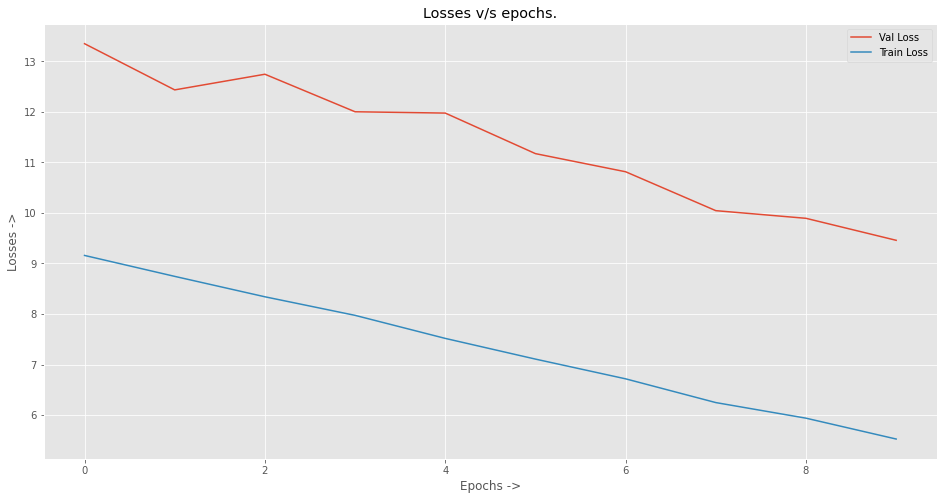

In [21]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(history.history['val_loss_val'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs ->')
plt.ylabel('Losses ->')
plt.title('Losses v/s epochs.')
plt.legend(['Val Loss','Train Loss'])
plt.show()

In [22]:
dict_1R={}
for k,v in dict_1.items():
  dict_1R[v]=k

In [23]:
labels_=model.predict(XVal_fin)
i=0 # i-th example from val dataset.
cnt=0
print()
for x in XVal_[0]:
  print('{} {}'.format(x[0],dict_1R[labels_[i][cnt]]))
  cnt+=1

1/1 [==============================] - 1s 1s/step

Amazon O
is O
looking O
for O
DevOps O
engineer S
UNK O
UNK UNK
UNK UNK
UNK UNK


In [24]:
dict_1

{'C': 0, 'O': 1, 'J': 2, 'S': 3, 'UNK': 4}

In [25]:
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

def labelIt(yVal):
  yVal_lis=[]
  for y1 in yVal:
    temp=[]
    for y2 in y1:
      temp.append(dict_1R[y2])
    yVal_lis.append(temp)
  return yVal_lis 

yVal_=labelIt(yVal)
yPred_=labelIt(labels_)
labls=['C','J','S','O','UNK']
metrics.flat_f1_score(yVal_,yPred_,average='weighted',labels=labls)

0.5428571428571429

In [32]:
print(metrics.flat_classification_report(yVal_,yPred_,labels=labls,digits=3))

              precision    recall  f1-score   support

           C      0.000     0.000     0.000         1
           J      0.000     0.000     0.000         2
           S      0.000     0.000     0.000         0
           O      0.500     1.000     0.667         3
         UNK      1.000     0.750     0.857         4

    accuracy                          0.600        10
   macro avg      0.300     0.350     0.305        10
weighted avg      0.550     0.600     0.543        10

